## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/Users/hahaha/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
earlystop2 = EarlyStopping(monitor = 'val_accuracy', patience = 5, verbose = 1)
earlystop3 = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)
earlystop4 = EarlyStopping(monitor = 'val_loss', patience = 25, verbose = 1)

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

test = [earlystop, earlystop2]
test2 = [earlystop, earlystop3, earlystop4]

for stop in test:
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[stop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_tag = 'exp-%s' % (str(stop))
    results[exp_tag] = {"train-loss": train_loss, "valid-loss": valid_loss, "train-acc": train_acc, "valid-acc": valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

50000/50000 [==============================] - 6s 119us/step - loss: 1.3556 - accuracy: 0.5262 - val_loss: 1.5305 - val_accuracy: 0.4624
Epoch 9/50
50000/50000 [==============================] - 6s 116us/step - loss: 1.3246 - accuracy: 0.5388 - val_loss: 1.5057 - val_accuracy: 0.4747
Epoch 10/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.2932 - accuracy: 0.5505 - val_loss: 1.4899 - val_accuracy: 0.4733
Epoch 11/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.2665 - accuracy: 0.5611 - val_loss: 1.4845 - val_accuracy: 0.4803
Epoch 12/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.2399 - accuracy: 0.5690 - val_loss: 1.4779 - val_accuracy: 0.4799
Epoch 13/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.2140 - accuracy: 0.5805 - val_loss: 1.4840 - val_accuracy: 0.4794
Epoch 14/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.1884 - accuracy: 0.5897 - val_loss: 

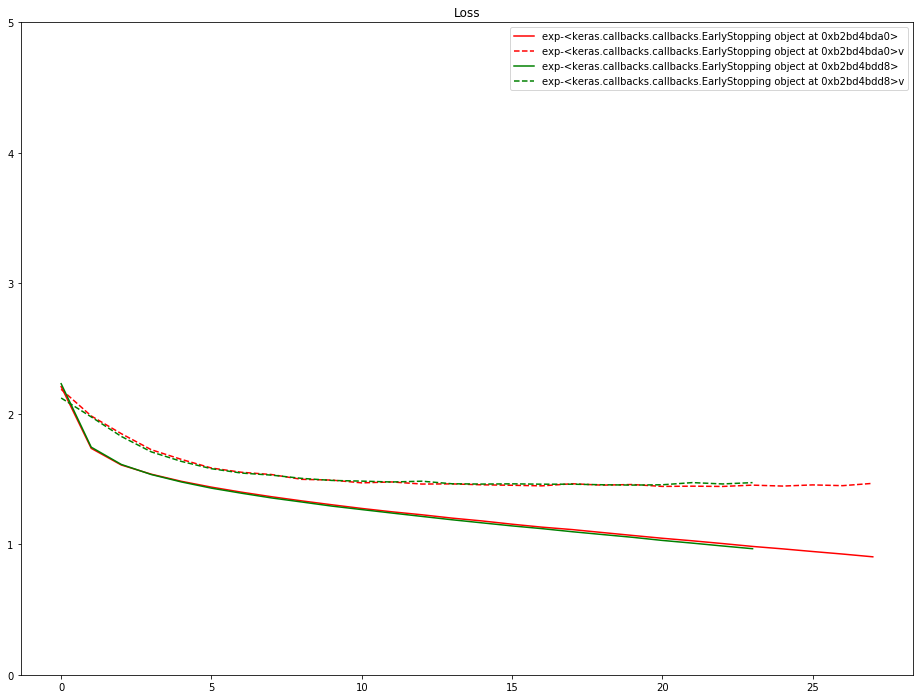

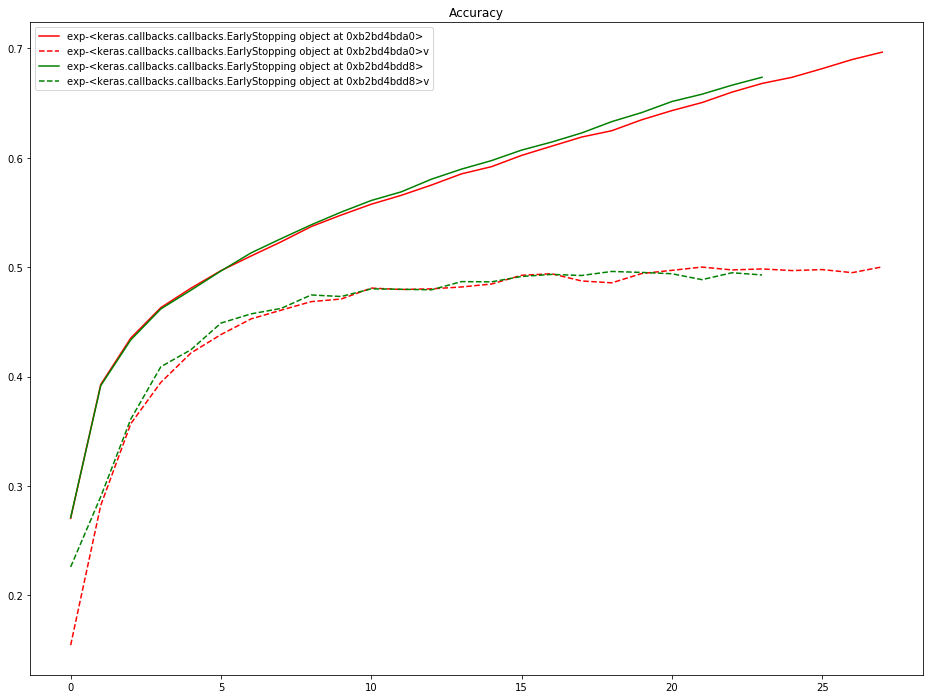

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "c"]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond+'v', color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond+'v', color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [9]:
results2 = {}

for stop in test2:
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[stop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_tag = 'exp-%s' % (str(stop))
    results2[exp_tag] = {"train-loss": train_loss, "valid-loss": valid_loss, "train-acc": train_acc, "valid-acc": valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

50000/50000 [==============================] - 5s 107us/step - loss: 1.2056 - accuracy: 0.5831 - val_loss: 1.4816 - val_accuracy: 0.4743
Epoch 15/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.1817 - accuracy: 0.5950 - val_loss: 1.4890 - val_accuracy: 0.4764
Epoch 16/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.1591 - accuracy: 0.5997 - val_loss: 1.4774 - val_accuracy: 0.4808 1.1581 
Epoch 17/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.1347 - accuracy: 0.6088 - val_loss: 1.4775 - val_accuracy: 0.4869
Epoch 18/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.1131 - accuracy: 0.6196 - val_loss: 1.4825 - val_accuracy: 0.4821
Epoch 19/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.0903 - accuracy: 0.6258 - val_loss: 1.4766 - val_accuracy: 0.4834
Epoch 20/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.0683 - accuracy: 0.6353 - v

Epoch 27/50
50000/50000 [==============================] - 6s 115us/step - loss: 0.9221 - accuracy: 0.6902 - val_loss: 1.4567 - val_accuracy: 0.4942
Epoch 28/50
50000/50000 [==============================] - 6s 117us/step - loss: 0.9013 - accuracy: 0.6981 - val_loss: 1.4537 - val_accuracy: 0.4999
Epoch 29/50
50000/50000 [==============================] - 6s 116us/step - loss: 0.8823 - accuracy: 0.7062 - val_loss: 1.4554 - val_accuracy: 0.5027
Epoch 30/50
50000/50000 [==============================] - 6s 116us/step - loss: 0.8623 - accuracy: 0.7145 - val_loss: 1.4625 - val_accuracy: 0.5011
Epoch 31/50
50000/50000 [==============================] - 6s 118us/step - loss: 0.8434 - accuracy: 0.7205 - val_loss: 1.4662 - val_accuracy: 0.5037
Epoch 32/50
50000/50000 [==============================] - 6s 117us/step - loss: 0.8241 - accuracy: 0.7287 - val_loss: 1.4803 - val_accuracy: 0.4999
Epoch 33/50
50000/50000 [==============================] - 6s 116us/step - loss: 0.8031 - accuracy: 0.7393

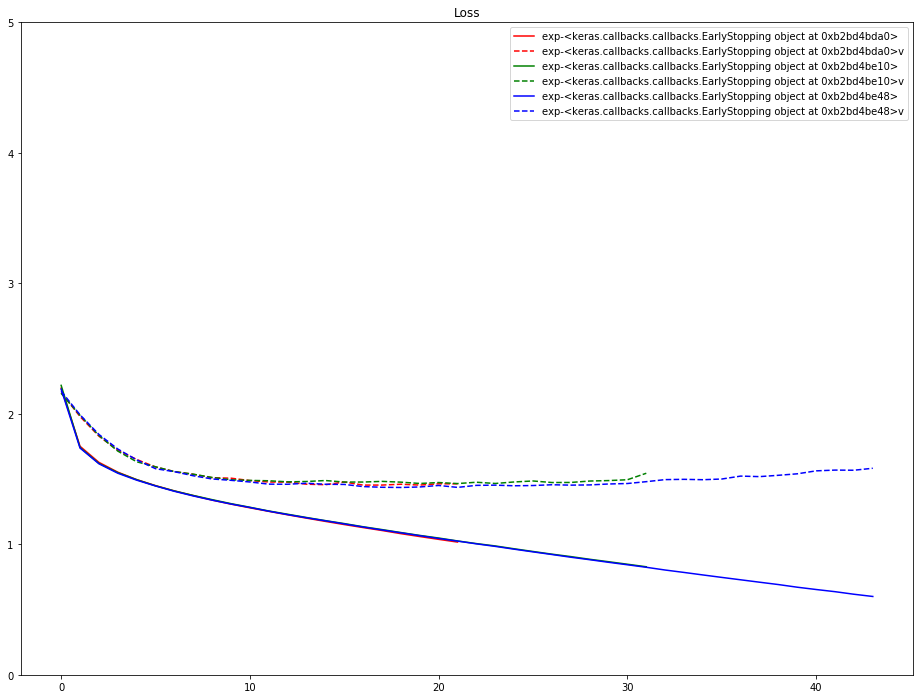

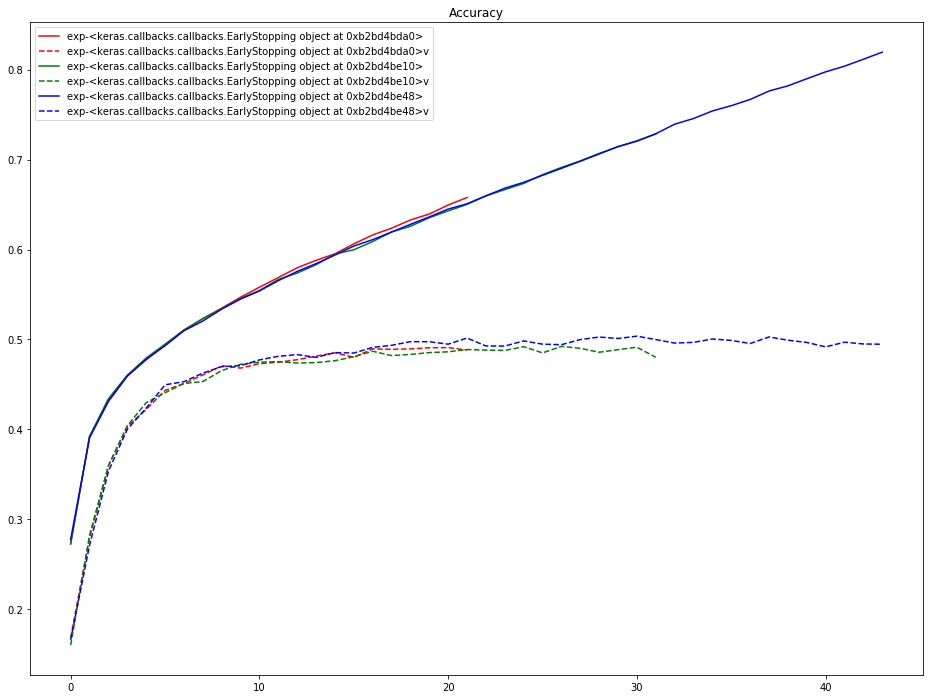

In [10]:
color_bar = ["r", "g", "b", "y", "m", "k", "c"]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results2.keys()):
    plt.plot(range(len(results2[cond]['train-loss'])),results2[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid-loss'])),results2[cond]['valid-loss'], '--', label=cond+'v', color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results2.keys()):
    plt.plot(range(len(results2[cond]['train-acc'])),results2[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid-acc'])),results2[cond]['valid-acc'], '--', label=cond+'v', color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()